In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from scipy.stats import powerlaw
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
def homophily(G, source, target, homophily_table):
    """
    Calculates homophily between two types of nodes.
    """
    if source == target:
        return 0
    if G.has_edge(source, target):
        return 0

    source_type = G.nodes[source]['type']
    target_type = G.nodes[target]['type']
    return homophily_table[source_type][target_type]

def assign_types(G, perc_majority, perc_partisan):
    for i in range(len(G.nodes)):
        if random.random() < perc_majority:
            if random.random() < perc_partisan:
                G.nodes[i]['type'] = 'maj_partisan'
            else:
                G.nodes[i]['type'] = 'maj'
        else:
            if random.random() < perc_partisan:
                G.nodes[i]['type'] = 'min_partisan'
            else:
                G.nodes[i]['type'] = 'min'

def assign_opinions(G):
    for i in range(len(G.nodes)):
        node_type = G.nodes[i]['type']
        if node_type == 'maj' or node_type == 'maj_partisan':
            G.nodes[i]['opinion'] = 1
        else:
            G.nodes[i]['opinion'] = 0

def generate_links(G, homophily_table, num_links):
    # generate stubs
    stubs = []
    for i in range(len(num_links)):
        for j in range(num_links[i]):
            stubs.append(i)
    selected = [False] * len(stubs)

    for i in range(len(stubs)):
        if selected[i]:
            continue
        attach_pmf = np.array([0 if selected[j] else homophily(
            G, stubs[i], stubs[j], homophily_table) for j in range(len(stubs))
            ])
        if np.sum(attach_pmf) == 0:
            continue
        attach_pmf = attach_pmf / np.sum(attach_pmf)
        target = np.random.choice(len(stubs), p=attach_pmf)
        G.add_edge(stubs[i], stubs[target])
        selected[i] = True
        selected[target] = True

def visualize(G):
    pos = nx.spring_layout(G)
    colors = ['plum' if G.nodes[node]['type'] == 'maj'
              else 'indigo' if G.nodes[node]['type'] == 'maj_partisan'
              else 'palegreen' if G.nodes[node]['type'] == 'min'
              else 'darkgreen' for node in G.nodes()]
    nx.draw(G, pos, node_color=colors)
    plt.show()



In [3]:
import statistics

def compute_neighbor_opinions(G):
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors is not None and len(neighbors) > 0:
            neighbor_opinions = [G.nodes[neighbor]['opinion'] for neighbor in neighbors]
            G.nodes[node]['neighbor_opinion'] = statistics.mean(neighbor_opinions) if len(neighbor_opinions) > 0 else None
        else:
            G.nodes[node]['neighbor_opinion'] = None

def compute_avg_neighbor_opinions_per_type(G):
    type_to_neighbor_opinions = {'maj': [], 'min': [], 'maj_partisan': [], 'min_partisan': []}

    for node in G.nodes():
        node_type = G.nodes[node]['type']
        node_neighbor_opinion = G.nodes[node]['neighbor_opinion']
        if node_neighbor_opinion is not None:
            type_to_neighbor_opinions[node_type].append(node_neighbor_opinion)

    output = {}
    for node_type in type_to_neighbor_opinions:
        avg_neighbor_opinion = statistics.mean(type_to_neighbor_opinions[node_type]) if len(type_to_neighbor_opinions[node_type]) > 0 else None
        output[f'{node_type}_opinion'] = avg_neighbor_opinion
    return output

def print_neighbor_opinions_per_type(opinions):
    for node_type_opinion, avg_neighbor_opinion in opinions.items():
        node_type = node_type_opinion.split('_opinion')[0]

        if avg_neighbor_opinion is not None:
            print(f"Mean neighbor opinion for {node_type}: {avg_neighbor_opinion}")

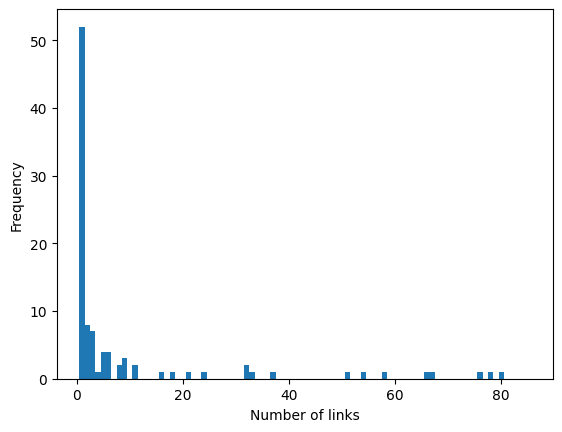

Total expected links: 1031
Percent majority nodes: 0.32
Percent minority nodes: 0.14
Percent majority-partisan nodes: 0.4
Percent minority-partisan nodes: 0.14
Finished generating graph
Total number of links: 296


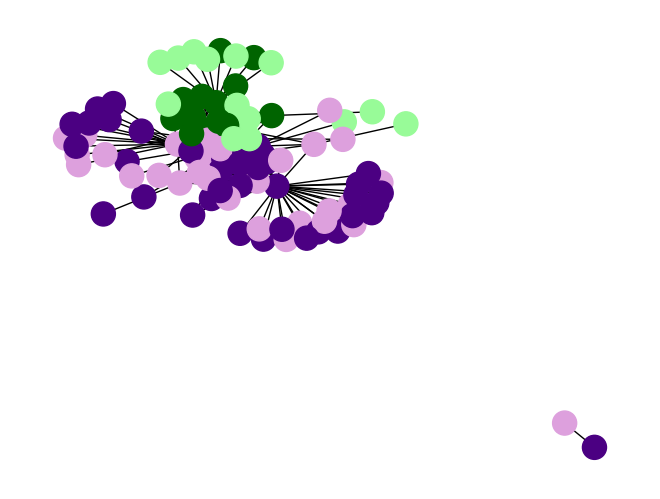

In [4]:
random_state = 124
random.seed(random_state)
np.random.seed(random_state)

n = 100
perc_majority = 0.75
perc_partisan = 0.5
homophily_table = {
    'maj': {'maj': 1, 'min': 1, 'maj_partisan': 1, 'min_partisan': 1},
    'min': {'maj': 1, 'min': 1, 'maj_partisan': 1, 'min_partisan': 1},
    'maj_partisan': {'maj': 1, 'min': 0, 'maj_partisan': 1, 'min_partisan': 0},
    'min_partisan': {'maj': 0, 'min': 1, 'maj_partisan': 0, 'min_partisan': 1}
}
powerlaw_alpha = 0.1
powerlaw_start = 1
powerlaw_scale = n-1

num_links = [round(val) for val in powerlaw.rvs(
    powerlaw_alpha,
    loc=powerlaw_start,
    scale=powerlaw_scale,
    size=n,
    random_state=random_state)
]

# plot histogram of num_links
plt.hist(num_links, bins=np.arange(min(num_links), max(num_links)+1)-0.5)
plt.xlabel('Number of links')
plt.ylabel('Frequency')
plt.show()

print(f"Total expected links: {sum(num_links)}")

G = nx.Graph()
G.add_nodes_from(range(n))

assign_types(G, perc_majority, perc_partisan)
print(f"Percent majority nodes: {len([node for node in G.nodes() if G.nodes[node]['type'] == 'maj'])/n}")
print(f"Percent minority nodes: {len([node for node in G.nodes() if G.nodes[node]['type'] == 'min'])/n}")
print(f"Percent majority-partisan nodes: {len([node for node in G.nodes() if G.nodes[node]['type'] == 'maj_partisan'])/n}")
print(f"Percent minority-partisan nodes: {len([node for node in G.nodes() if G.nodes[node]['type'] == 'min_partisan'])/n}")

generate_links(G, homophily_table, num_links)
assign_opinions(G)

print(f"Finished generating graph")
print(f"Total number of links: {G.number_of_edges()}")

visualize(G)

In [6]:
compute_neighbor_opinions(G)
opinions = compute_avg_neighbor_opinions_per_type(G)
print_neighbor_opinions_per_type(opinions)

Mean neighbor opinion for maj: 0.8214918658611494
Mean neighbor opinion for min: 0.2992063492063492
Mean neighbor opinion for maj_partisan: 0.9853677536231884
Mean neighbor opinion for min_partisan: 0.28195435516864087


In [4]:
def run_simulation(param_set, n, homophily_table, powerlaw_alpha, powerlaw_start, powerlaw_scale, random_state):

    perc_majority = param_set['perc_majority']
    perc_partisan = param_set['perc_partisan']

    num_links = [round(val) for val in powerlaw.rvs(
        powerlaw_alpha,
        loc=powerlaw_start,
        scale=powerlaw_scale,
        size=n,
        random_state=random_state)
    ]

    G = nx.Graph()
    G.add_nodes_from(range(n))

    assign_types(G, perc_majority, perc_partisan)
    real_perc_majority = len([node for node in G.nodes() if G.nodes[node]['type'] == 'maj'])/n
    real_perc_minority = len([node for node in G.nodes() if G.nodes[node]['type'] == 'min'])/n
    real_perc_maj_partisan = len([node for node in G.nodes() if G.nodes[node]['type'] == 'maj_partisan'])/n
    real_perc_min_partisan = len([node for node in G.nodes() if G.nodes[node]['type'] == 'min_partisan'])/n
    real_perc_overal_majority = real_perc_majority + real_perc_maj_partisan
    real_perc_overal_minority = real_perc_minority + real_perc_min_partisan

    generate_links(G, homophily_table, num_links)
    assign_opinions(G)

    compute_neighbor_opinions(G)
    output = compute_avg_neighbor_opinions_per_type(G)

    output['perc_majority_sim'] = real_perc_majority
    output['perc_minority_sim'] = real_perc_minority
    output['perc_maj_partisan_sim'] = real_perc_maj_partisan
    output['perc_min_partisan_sim'] = real_perc_min_partisan
    output['perc_overal_majority_sim'] = real_perc_overal_majority
    output['perc_overal_minority_sim'] = real_perc_overal_minority

    output['n'] = n
    output['perc_majority_param'] = perc_majority
    output['perc_partisan_param'] = perc_partisan
    output['powerlaw_alpha'] = powerlaw_alpha
    output['powerlaw_start'] = powerlaw_start
    output['powerlaw_scale'] = powerlaw_scale
    if random_state is not None:
        output['random_state'] = random_state

    reformatted_output = {key: [value] for key, value in output.items()}
    return pd.DataFrame.from_dict(reformatted_output)

def run_simulations(n, perc_majority_vals, perc_partisan_vals, homophily_table, powerlaw_alpha, powerlaw_start, powerlaw_scale, random_state, repetitions=1):
    output = None
    params = [{'perc_majority': perc_majority, 'perc_partisan': perc_partisan, 'rep': i}
              for perc_majority in perc_majority_vals for perc_partisan in perc_partisan_vals for i in range(repititions)]

    results = Parallel(n_jobs=-1)(
        delayed(run_simulation)(param_set,
                                n,
                                homophily_table,
                                powerlaw_alpha,
                                powerlaw_start,
                                powerlaw_scale,
                                random_state)
        for param_set in tqdm(params, desc='Running simulations')
    )
    return pd.concat(results, ignore_index=True)
    # for param_set in tqdm(params, desc='Running simulations'):
    #     result = run_simulation(param_set, n, homophily_table, powerlaw_alpha, powerlaw_start, powerlaw_scale, random_state)
    #     reformatted_result = {key: [value] for key, value in result.items()}
    #     if output is None:
    #         output = pd.DataFrame.from_dict(reformatted_result)
    #     else:
    #         output = pd.concat([output, pd.DataFrame.from_dict(reformatted_result)], ignore_index=True)
    # return output

In [11]:
n = 200
homophily_table = {
    'maj': {'maj': 1, 'min': 1, 'maj_partisan': 1, 'min_partisan': 1},
    'min': {'maj': 1, 'min': 1, 'maj_partisan': 1, 'min_partisan': 1},
    'maj_partisan': {'maj': 1, 'min': 0, 'maj_partisan': 1, 'min_partisan': 0},
    'min_partisan': {'maj': 0, 'min': 1, 'maj_partisan': 0, 'min_partisan': 1}
}
powerlaw_alpha = 0.1
powerlaw_start = 1
powerlaw_scale = n-1
perc_majority_vals = [0.5]
perc_partisan_vals = np.arange(0, 0.76, 0.05).tolist()
random_state=None
repititions = 10

output = run_simulations(n, perc_majority_vals, perc_partisan_vals, homophily_table, powerlaw_alpha, powerlaw_start, powerlaw_scale, random_state, repetitions=2)


Running simulations: 100%|██████████| 160/160 [03:20<00:00,  1.25s/it]
C:\Users\gabem\AppData\Local\Temp\ipykernel_30784\898439005.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(results, ignore_index=True)


In [6]:
print(output)

     maj_opinion  min_opinion  maj_partisan_opinion  min_partisan_opinion  \
0       0.601705     0.596635                   NaN                   NaN   
1       0.783211     0.771746                   NaN                   NaN   
2       0.941622     0.958957                   NaN                   NaN   
3       0.927649     0.902226                   NaN                   NaN   
4       0.914946     0.934981                   NaN                   NaN   
..           ...          ...                   ...                   ...   
105     0.836518     0.244117              0.891988              0.128767   
106     0.695284     0.601424              0.737746              0.575341   
107     0.658041     0.230259              0.726988              0.104248   
108     0.902900     0.245325              0.973898              0.290218   
109     0.869550     0.306227              0.817373              0.096776   

     perc_majority_sim  perc_minority_sim  perc_maj_partisan_sim  \
0      

In [7]:
def visualize_simulations(output, param_of_interest):
    # group the output by the parameter of interest
    # get the mean and standard deviation of the opinion scores
    grouped = output.groupby(param_of_interest)[
        ['maj_opinion','min_opinion','maj_partisan_opinion','min_partisan_opinion']
        ].agg(['mean','std'])

    grouped = grouped.reset_index()

    # visualize the aggregated scores with error bars of the standard deviations
    plt.errorbar(grouped[param_of_interest], grouped['maj_opinion']['mean'], yerr=grouped['maj_opinion']['std'], label='majority', fmt='-', color='blue')
    plt.errorbar(grouped[param_of_interest], grouped['min_opinion']['mean'], yerr=grouped['min_opinion']['std'], label='minority', fmt='-', color='red')
    plt.errorbar(grouped[param_of_interest], grouped['maj_partisan_opinion']['mean'], yerr=grouped['maj_partisan_opinion']['std'], label='majority-partisan', fmt='-', color='green')
    plt.errorbar(grouped[param_of_interest], grouped['min_partisan_opinion']['mean'], yerr=grouped['min_partisan_opinion']['std'], label='minority-partisan', fmt='-', color='purple')

    plt.xlabel(param_of_interest)
    plt.ylabel('Opinion')
    plt.title(f'Opinion scores by {param_of_interest}')
    plt.legend()
    plt.show()


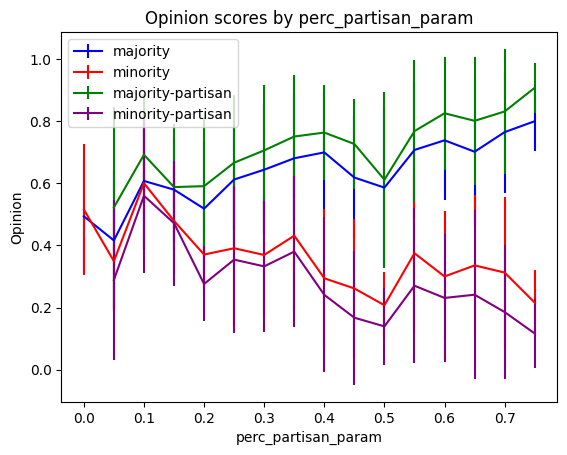

In [12]:
visualize_simulations(output, 'perc_partisan_param')